## Introduction

This notebook is based on lesson 1 ["Is it a bird?"](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) from fast.ai's course "Practical Deep Lerning for Coders".

The basic steps for image classification are:

1. Use DuckDuckGo to search for images of two categories (birds and forest, cat and dog, ...)
2. Fine-tune a pre-trained neural network to recognise these two groups
3. Try running this model on a random picture of one category and see if it works.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.


## Step 1: Download images 

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

categories = 'cannabis', 'rose'
suffix = 'photo'
path = Path('downloads')

In [3]:
for c in categories:
    urls = search_images(c + ' ' + suffix, max_images = 1)
    dest = c + '.jpg'
    download_url(urls[0], dest, show_progress=False)

Searching for 'cannabis photo'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'rose photo'


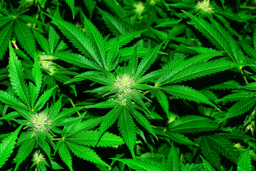

In [4]:
Image.open(categories[0] + '.jpg').to_thumb(256,256)

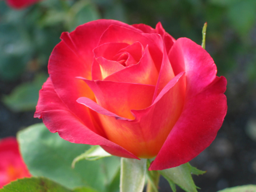

In [5]:
Image.open(categories[1] + '.jpg').to_thumb(256,256)

In [6]:
for c in categories:
    dest = (path/c)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{c} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/c, max_size=400, dest=path/c)
    
# drop incomplete downloads
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

Searching for 'cannabis photo'
Searching for 'rose photo'


0

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

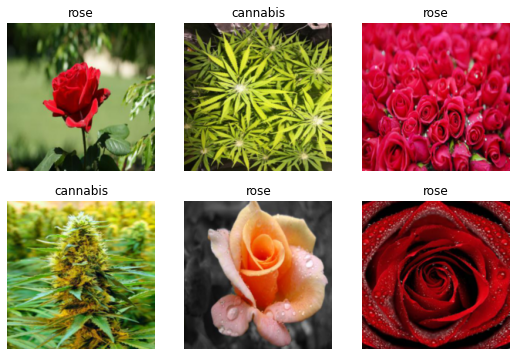

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.954119,4.925553,0.545455,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.055461,3.429432,0.545455,00:00
1,0.915004,0.816638,0.545455,00:00
2,0.672244,0.135528,0.000000,00:00


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model 

In [9]:
pred,_,probs = learn.predict(PILImage.create('/kaggle/working/cannabis.jpg'))
print(pred,_,probs)
print(f"Predicted category: {pred}.")
print(f"Probability: {probs[0]:.2f}")

cannabis tensor(0) tensor([0.9836, 0.0164])
Predicted category: cannabis.
Probability: 0.98


Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

## Further reading

* https://docs.fast.ai/
* https://timm.fast.ai/

Useful tools:
* [Pixspy](https://de.pixspy.com/)
